In [1]:
!pip install torch torchvision pandas numpy matplotlib scikit-learn

In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

In [27]:
# Load and preprocess your data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SP500_data.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [28]:
# Hyperparameter grid
seq_lengths = [20, 30, 50]
hidden_sizes = [50, 100]
learning_rates = [0.001, 0.0005]
epochs = 300

In [29]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs).float(), torch.tensor(ys).float()

In [30]:
# LSTM Model Definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.lstm.hidden_size)
        c0 = torch.zeros(2, x.size(0), self.lstm.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [31]:
# Store best hyperparameters and loss
best_loss = float('inf')
best_params = {}

# Grid search loop
for seq_length, hidden_size, lr in itertools.product(seq_lengths, hidden_sizes, learning_rates):
    print(f"Testing: seq_length={seq_length}, hidden_size={hidden_size}, lr={lr}")

    # Create sequences
    X, y = create_sequences(data_scaled, seq_length)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Model, loss, optimizer
    model = LSTM(input_size=1, hidden_size=hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Testing: seq_length=20, hidden_size=50, lr=0.001
Testing: seq_length=20, hidden_size=50, lr=0.0005
Testing: seq_length=20, hidden_size=100, lr=0.001
Testing: seq_length=20, hidden_size=100, lr=0.0005
Testing: seq_length=30, hidden_size=50, lr=0.001
Testing: seq_length=30, hidden_size=50, lr=0.0005
Testing: seq_length=30, hidden_size=100, lr=0.001
Testing: seq_length=30, hidden_size=100, lr=0.0005
Testing: seq_length=50, hidden_size=50, lr=0.001
Testing: seq_length=50, hidden_size=50, lr=0.0005
Testing: seq_length=50, hidden_size=100, lr=0.001
Testing: seq_length=50, hidden_size=100, lr=0.0005


In [32]:
# Training loop
for epoch in range(epochs):
  model.train()
  outputs = model(X_train)
  loss = criterion(outputs, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

In [33]:
# Prediction
model.eval()
with torch.no_grad():
  predictions = model(X_test).numpy()

In [34]:
# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.numpy())

In [35]:
# Evaluation Metrics
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

# Update best parameters if improved
if mse < best_loss:
  best_loss = mse
  best_params = {
    'seq_length': seq_length,
    'hidden_size': hidden_size,
    'learning_rate': lr,
    'mse': mse
        }
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f"R² Score: {r2:.4f}")
# Display the best hyperparameters
print("\nBest Hyperparameters:")
print(best_params)

MSE: 6092.4810
RMSE: 78.0543
MAE: 67.0019
R² Score: 0.9421

Best Hyperparameters:
{'seq_length': 50, 'hidden_size': 100, 'learning_rate': 0.0005, 'mse': 6092.48095703125}


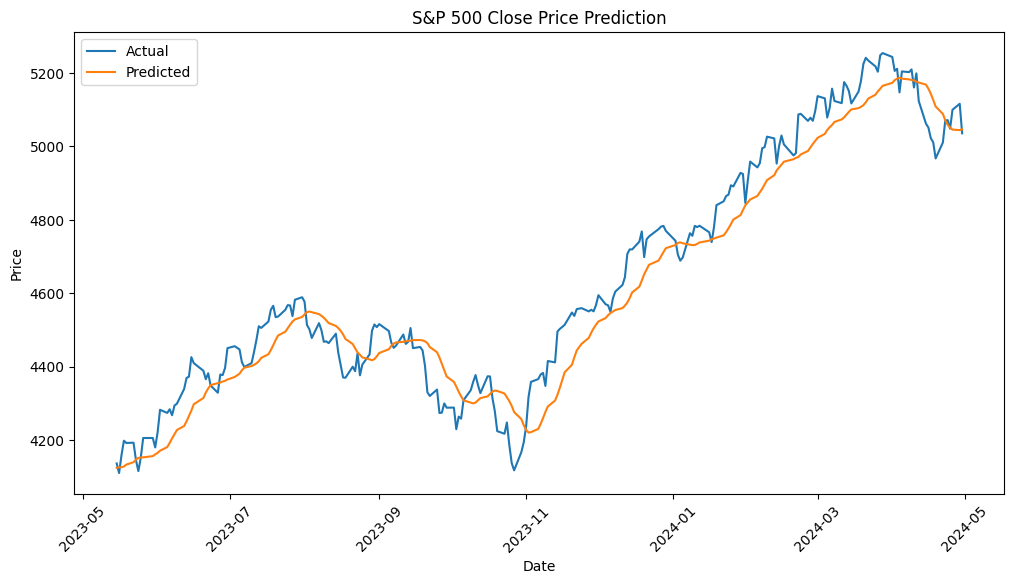

In [36]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(df['Date'][-len(actual):], actual, label='Actual')
plt.plot(df['Date'][-len(predictions):], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('S&P 500 Close Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [40]:
# Recursive forecasting

from datetime import timedelta

# Assuming your model, scaler, and data are already defined:
# model, scaler, data_scaled

model.eval()

# Number of future days you want to predict
future_days = 60

# Use the last sequence from your data as initial input
seq_length = 50  # Your best hyperparameter
last_sequence = data_scaled[-seq_length:].reshape(1, seq_length, 1)
last_sequence = torch.tensor(last_sequence).float()

# List to store future predictions
future_predictions = []

for _ in range(future_days):
    with torch.no_grad():
        # Predict the next day
        next_pred = model(last_sequence)

        # Append prediction
        future_predictions.append(next_pred.item())

        # Update last_sequence (drop first element, add new prediction)
        next_pred_array = next_pred.numpy().reshape(1, 1, 1)
        last_sequence = torch.cat((last_sequence[:, 1:, :], torch.tensor(next_pred_array)), dim=1)

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates
last_date = pd.to_datetime(df['Date'].iloc[-1])
future_dates = [last_date + timedelta(days=x) for x in range(1, future_days+1)]

# Create DataFrame for clear visualization
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions.flatten()
})

print(future_df.head())

        Date  Predicted_Close
0 2024-05-01      5046.484060
1 2024-05-02      5045.493588
2 2024-05-03      5043.906999
3 2024-05-04      5041.920840
4 2024-05-05      5039.683107


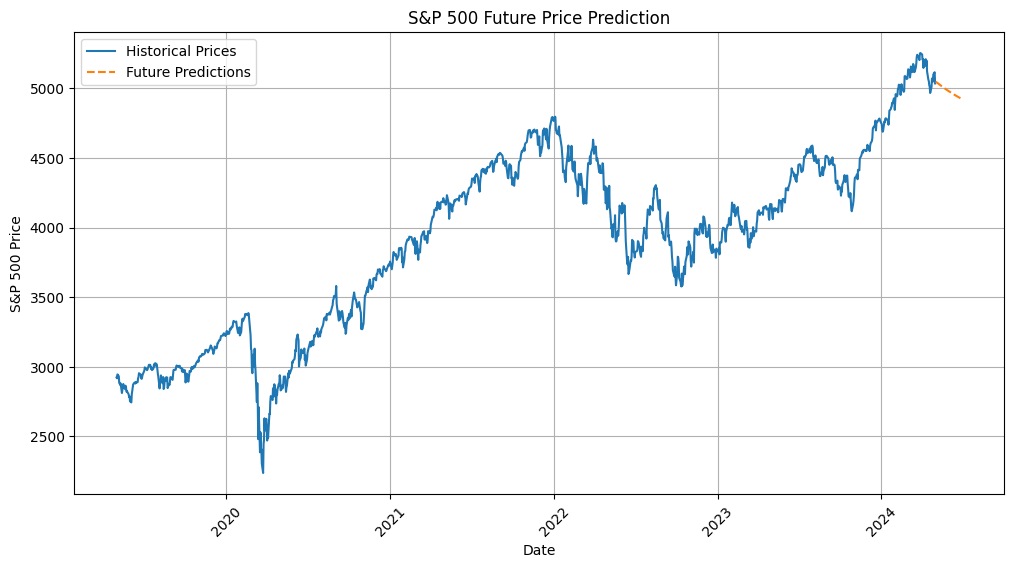

In [41]:
plt.figure(figsize=(12,6))
# Plot historical data
plt.plot(df['Date'], df['Close'], label='Historical Prices')
# Plot future predictions
plt.plot(future_df['Date'], future_df['Predicted_Close'], label='Future Predictions', linestyle='--')

plt.xlabel('Date')
plt.ylabel('S&P 500 Price')
plt.title('S&P 500 Future Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()